In [1]:
from modules.models import HeatPinn
from modules.data import simulate_heat
from modules.plots import plot_heat_model, plot_training_loss
import tensorflow as tf
import numpy as np

In [2]:
k = 1/4
x_start = 0
length = 2

def phi_function(tx):
    return 2 * tf.sin(np.pi*tx[:, 1:] / 2) - tf.sin(np.pi*tx[:, 1:]) +\
        4 * tf.sin(2 * np.pi*tx[:, 1:])

def boundary_function(tx):
    return tf.zeros_like(tx[:, 1:])


def u_exact(tx):
    return 2 * tf.sin(np.pi*tx[:, 1:] / 2) * tf.exp(-tf.square(np.pi) / 16 * tx[:, :1]) -\
        tf.sin(np.pi*tx[:, 1:]) * tf.exp(-tf.square(np.pi) / 4 * tx[:, :1]) -\
            tf.sin(2 * np.pi * tx[:, 1:]) * tf.exp(-tf.square(np.pi) * tx[:, :1])

In [3]:
(tx_eqn, y_res), (tx_init, y_init), (tx_res, y_res) = simulate_heat(1000, phi_function, boundary_function, length=2, time=2, random_seed=42, dtype=tf.float32)

In [ ]:
inputs = tf.stack([tx_eqn, tx_init, tx_res], axis=0)
outputs = tf.stack([y_init, y_res], axis=0)

In [ ]:
network = HeatPinn.build_network([32, 64])
model = HeatPinn(network, k)
model.compile()

In [ ]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(1e-3, decay_steps=1000, decay_rate=0.9)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

In [8]:
history = model.fit(inputs, outputs, 10000, optimizer, progress_interval=200)

Epoch: 0 Loss: 10.0645 Total Elapsed Time: 2.89
Epoch: 200 Loss: 8.5109 Total Elapsed Time: 5.42
Epoch: 400 Loss: 8.2505 Total Elapsed Time: 7.82
Epoch: 600 Loss: 8.0681 Total Elapsed Time: 10.24
Epoch: 800 Loss: 5.8745 Total Elapsed Time: 12.81
Epoch: 1000 Loss: 1.8411 Total Elapsed Time: 15.48
Epoch: 1200 Loss: 0.3652 Total Elapsed Time: 18.07
Epoch: 1400 Loss: 0.1404 Total Elapsed Time: 20.60
Epoch: 1600 Loss: 0.0816 Total Elapsed Time: 23.02
Epoch: 1800 Loss: 0.0462 Total Elapsed Time: 25.38
Epoch: 2000 Loss: 0.0262 Total Elapsed Time: 27.71
Epoch: 2200 Loss: 0.0162 Total Elapsed Time: 30.02
Epoch: 2400 Loss: 0.0122 Total Elapsed Time: 32.31
Epoch: 2600 Loss: 0.0099 Total Elapsed Time: 34.62
Epoch: 2800 Loss: 0.0086 Total Elapsed Time: 36.93
Epoch: 3000 Loss: 0.0071 Total Elapsed Time: 39.26
Epoch: 3200 Loss: 0.0062 Total Elapsed Time: 41.56
Epoch: 3400 Loss: 0.0054 Total Elapsed Time: 43.86
Epoch: 3600 Loss: 0.0047 Total Elapsed Time: 46.42
Epoch: 3800 Loss: 0.0042 Total Elapsed T

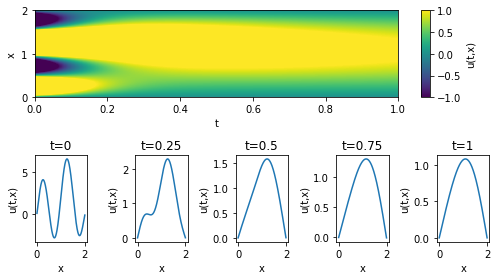

In [9]:
plot_heat_model(model.network, length, 1)

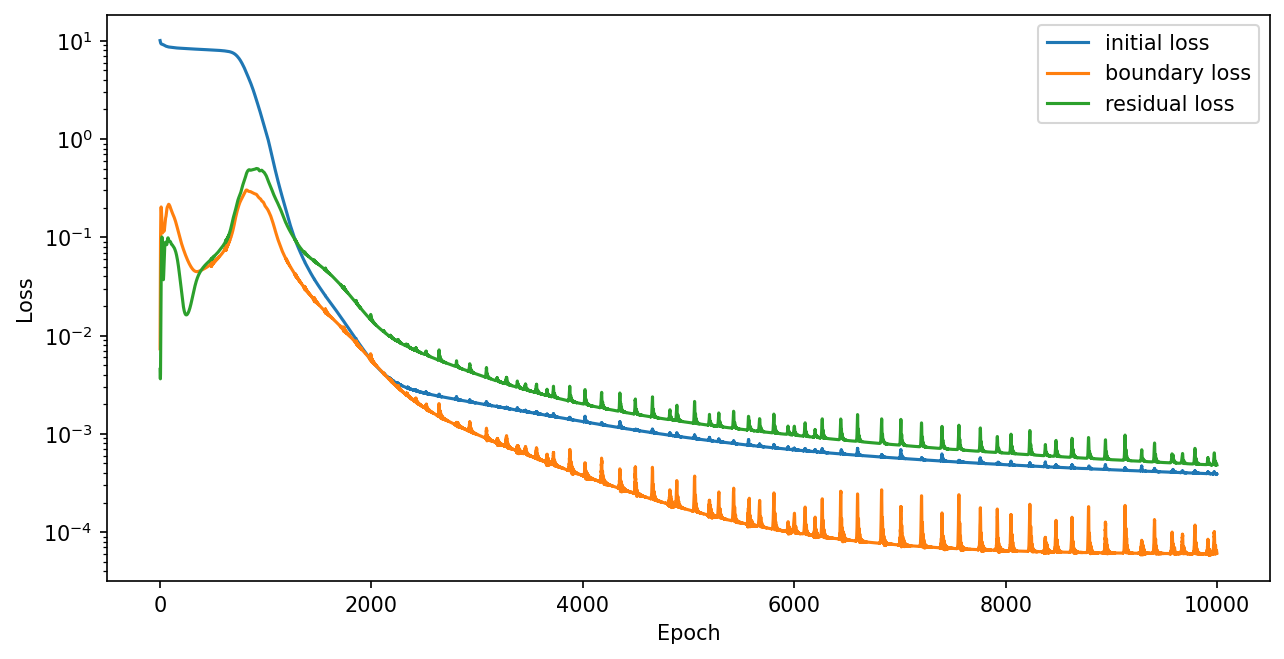

In [13]:
plot_training_loss(history, y_scale='log')

In [14]:
from tensorflow.keras.metrics import MeanAbsoluteError, MeanRelativeError

In [16]:
tx_train = tx_eqn
y_train = u_exact(tx_train)

In [20]:
mae_train = MeanAbsoluteError()
mre_train = MeanRelativeError(y_train)

In [21]:
mae_train.update_state(model.network.predict(tx_train), y_train)
mre_train.update_state(model.network.predict(tx_train), y_train)
mae_train.result().numpy(), mre_train.result().numpy()

(0.16228452, -0.10040358)

In [29]:
(tx_test, _), _, _ = simulate_heat(1000, phi_function, boundary_function, length=2, time=2, random_seed=10, dtype=tf.float32)
y_test = u_exact(tx_test)

In [30]:
mae_test = MeanAbsoluteError()
mre_test = MeanRelativeError(y_test)

In [31]:
mae_test.update_state(model.network.predict(tx_test), y_test)
mre_test.update_state(model.network.predict(tx_test), y_test)
mae_test.result().numpy(), mre_test.result().numpy()

(0.18011649, 0.056378737)